# Ray reflection

On this course so far, we have learned how to examine a range of surfaces (standard mathematical objects like planes spheres and cones; surface patches; 2D boxes; 3D parallelogram plane segments and triangular plane segments). We have also learned how to detect intersections between rays and these objects (and calculate normals at any intersection locations).

Now we will consider ray behaviour **after** intersecting an object. In this workbook we will review how to calculate the path of a ray which **reflects** off an object.


In [1]:
## Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import Axes3D, proj3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

3D arrows will again prove useful:

In [2]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

## Background

In the lectures we saw that the path of a ray after intersecting an object could be determined by knowing the incident vector direction, ${\mathbf{\vec{u}}}$ and the normal vector to the surface at the point of intersection ${\mathbf{\vec{n}}}$. If these are known, the reflected ray would travel along the vector ${\mathbf{\vec{v}}}$, which can be calculated according to:

$$
{\mathbf{\vec{v}}}={\mathbf{\vec{u}}}-2\left({{\mathbf{\vec{u}}}\cdot{\mathbf{\vec{n}}}}\right)\frac{{\mathbf{\vec{n}}}}{|{\mathbf{\vec{n}}}|^2}
$$

To examine the implications of this formula, we'll use two examples. We'll create a simple example using reflection from a plane, then used a more complicated example from the lectures.



In [3]:
def v(u,n):
    # reads in incident vector u and normal vector n
    # calculates v from reflection formula
    temp = 2 * u.dot(n) * n / np.linalg.norm(n) / np.linalg.norm(n)
    v = u - temp 
    return v

This formula makes use of normals. In the lectures we also saw to use the gradient function $\nabla{\phi}$ to evaluate the normal to a scalar surface $\phi$. In case we use this in the examples, we'll first define a function which returns this quantity if we input a scalar function.

In [4]:
x, y, z  = sym.Symbol('x'), sym.Symbol('y'), sym.Symbol('z')  #coordinates

def grad(phi):
    # gradient operator acting on scalar function phi(x,y,z)
    gradphi = [sym.diff(phi,x), sym.diff(phi,y), sym.diff(phi,z)]
    return gradphi

## Example 1: Reflection from a plane

**Determine the reflected ray equation for a ray incident upon the plane $2x-3y+z=4$ with equation**

$$
\begin{align}
    {\mathbf{\vec{r}}} &=
          \begin{pmatrix}
           0 \\           
           3 \\
           -3
          \end{pmatrix} +t
          \begin{pmatrix}
           -1 \\
           -3 \\
           2
         \end{pmatrix}
  \end{align}
$$

(this is a modified version of Example 1 from the lectures).

Our first step is going to be to visualise the plane and the ray:

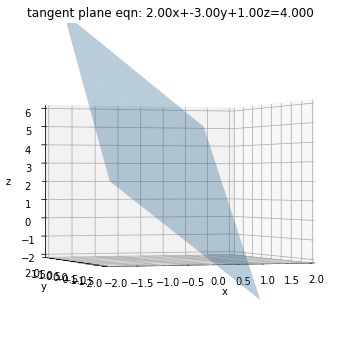

In [5]:
peqn = 2*x-3*y+1*z-4
pn = np.array(grad(peqn),dtype=np.float32)
d = -peqn.subs([(x, 0), (y, 0), (z, 0)])
tpeqn = "tangent plane eqn: {:.2f}x+{:.2f}y+{:.2f}z={:.3f}".format(pn[0],pn[1],pn[2],float(d))

xlim = -2,2
ylim = -2,2
zlim = -2,6
xx, yy = np.meshgrid(np.arange(*xlim), np.arange(*ylim))
zz = (d - pn[0] * xx - pn[1] * yy) / pn[2]
#zz[zz>6] = np.nan
#zz[zz<-2] = np.nan

# plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,6))
ax.view_init(elev=0, azim=250, roll=0)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_zlim(*zlim)
ax.plot_surface(xx, yy, zz, alpha=0.3, label='tangent plane')
ax.title.set_text(tpeqn)
#ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

We have created our plane as expected (note that this type of plane is infinite in extent, and hence Python struggles to know how to plot this).

Now we should define the incident ray:

In [6]:
#r = origin + t * v
r1_o = sym.Matrix([[0, -3, 0]])
r1v = sym.Matrix([[-1, 3, 2]])
t = sym.Symbol('t', positive=True) 
r1 = r1_o + t * r1v

We now need to look for intersections. On paper, we would substitute the parametric form of the ray equation into the plane equation. We can do this in Python too

In [7]:
# equate ray with cone, look for intersections
sols = sym.solve(peqn.subs([(x, r1[0]), (y, r1[1]), (z, r1[2])]),t)
valid_sols = [i for i in sols if i <= 1]
valid_sols.sort()
for i, val in enumerate(valid_sols) :
    print("intersection {} found at t={}".format(i+1,val.evalf()))
    
#convert intersections to useful datatypes
is1  = (r1.subs(t,sols[0].evalf()))
r1o  = np.array(r1_o.tolist()[0],dtype='float64')
is1a = np.array(is1.tolist()[0],dtype='float64')
print("intersection occurs at ({:0.3f},{:0.3f},{:0.3f})".format(is1a[0],is1a[1],is1a[2]))
r1vv  = np.array(r1v.tolist()[0],dtype='float64')
rr_o = sym.Matrix([is1a])

intersection 1 found at t=0.555555555555556
intersection occurs at (-0.556,-1.333,1.111)


Now that we have located the intersection point, we can use this as the origin for a new ray equation, generating the direction of this new ray using the subroutine we defined earlier `v(u,n)`:

In [8]:
#construct ray equation for reflected ray:
rr = is1a + t * v(r1vv,pn)
print("reflected ray eq:")
print(rr)

reflected ray eq:
[1.57142853736877*t - 0.555555555555556
 -0.857142686843872*t - 1.33333333333333
 3.28571426868439*t + 1.11111111111111]


The reflected ray equation obtained above looks good; the vector direction matches that determined in Example 1 in the lectures.

Can we visually confirm that the reflected ray is travelling in the correct direction?

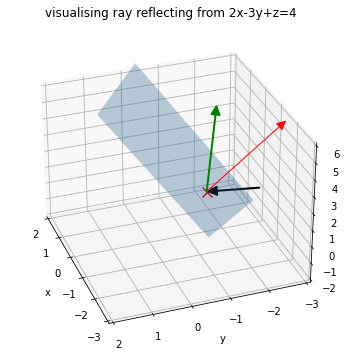

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,6))
ax.view_init(elev=30, azim=160, roll=0)
ax.set_zlim(-2,6)
ax.set_ylim(-3,2)
ax.set_xlim(-3,2)
ax.plot_surface(xx, yy, zz, alpha=0.3, label='positive cone')
ax.scatter(is1a[0],is1a[1],is1a[2], c='r', marker='x', s=100) 
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='k', shrinkA=0, shrinkB=0, linewidth=2)
a = Arrow3D([r1o[0], is1a[0]], [r1o[1], is1a[1]], [r1o[2], is1a[2]], **arrow_prop_dict)
ax.add_artist(a)
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='r', shrinkA=0, shrinkB=0, linewidth=1)
b = Arrow3D([is1a[0], is1a[0]+pn[0]], [is1a[1], is1a[1]+pn[1]], [is1a[2], is1a[2]+pn[2]], **arrow_prop_dict)
ax.add_artist(b)
#to plot reflected ray, pick value of t to create end point for arrow
tep=1
ep = [float(rr[0].subs({t:tep})),float(rr[1].subs({t:tep})),float(rr[2].subs({t:tep}))]
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='g', shrinkA=0, shrinkB=0, linewidth=2)
b = Arrow3D([is1a[0], ep[0]], [is1a[1], ep[1]], [is1a[2], ep[2]], **arrow_prop_dict)
ax.add_artist(b)
ax.title.set_text('visualising ray reflecting from 2x-3y+z=4')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z");

In the above figure, we can see that the incident ray (blue) arrives at the plane (blue) at the intersection point we found (red cross). The normal at the point of intersection (red arrow) does look perpendicular to the plane. The reflected ray (green) also appears to be a reflection of the incident ray in the plane.

NB. be careful when plotting normals to planes using Python; subtle changes to minor quantities like plot axis ranges can make vectors appear to point in the wrong direction, which would solely be a plotting artefact and not a true error.

Thus we've seen that we can reflect objects from a simple plane. What about if we try more complex objects?

### Lecture Example 2
**A ray is defined by its vector equation as $\vec{r}=2\vec{i}-\vec{j}+3\vec{k}+t\left(\vec{i}+\vec{j}+\vec{k}\right)$. Determine the point where it first intersects the surface of the cone $x^2+y^2=z^2$ and hence obtain the equation of the reflected ray from this surface.**

Lets begin by visualising the cone and the ray, using code recycled from the curves and surfaces workbook:

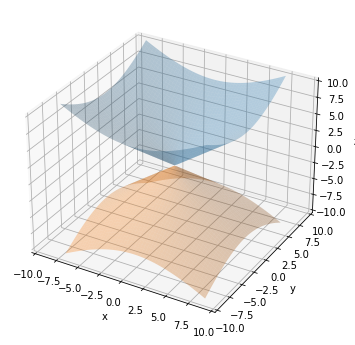

In [10]:
xlim = -10,10
ylim = -10,10
zlim = -10,10

xrange2 = np.linspace(-8, 8, 100)
yrange2 = np.linspace(-8, 8, 100)
X2, Y2 = np.meshgrid(xrange2, yrange2)
#remember because z^2=x^2+y^2, z=+/-sqrt(x^2+y^2)
Z2 = np.sqrt(X2**2+Y2**2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,6))
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_zlim(*zlim)
ax.plot_surface(X2, Y2, Z2, alpha=0.3, label='positive cone')
ax.plot_surface(X2, Y2, -Z2, alpha=0.3, label='negative cone')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

Lets now define a scalar function $\phi$ for the surface of this cone:

In [11]:
cone = x**2+y**2-z**2
print(grad(cone))

[2*x, 2*y, -2*z]


Once again, as shown above, we can use our `grad()` subroutine to calculate the gradient function for us.

Lets set up the rest of the problem, creating a ray, seeking intersection locations and 

In [16]:
#setting up ray equation
r2_o = sym.Matrix([[2, -1, 3]])
r2v = sym.Matrix([[1, 1, 1]])
t = sym.Symbol('t', positive=True) 
r2 = r2_o + t * r2v

# equate ray with cone, look for intersections
sols = sym.solve(cone.subs([(x, r2[0]), (y, r2[1]), (z, r2[2])]),t)
valid_sols = [i for i in sols if i <= 1]
valid_sols.sort()
for i, val in enumerate(valid_sols) :
    print("intersection {} found at t={}".format(i+1,val.evalf()))
    
#convert intersections to useful datatypes
is2  = (r2.subs(t,sols[0].evalf()))
r2o  = np.array(r2_o.tolist()[0],dtype='float64')
is2a = np.array(is2.tolist()[0],dtype='float64')
print("intersection occurs at ({:0.3f},{:0.3f},{:0.3f})".format(is2a[0],is2a[1],is2a[2]))
print("--")
#calculate grad(phi) for cone at point of intersection
gc = grad(cone)
nx = float(gc[0].subs({x:is2a[0], y:is2a[1], z:is2a[2]}))
ny = float(gc[1].subs({x:is2a[0], y:is2a[1], z:is2a[2]}))
nz = float(gc[2].subs({x:is2a[0], y:is2a[1], z:is2a[2]}))
cn = np.array([nx,ny,nz],dtype=np.float32)

#set up ray equation for reflected ray
r2vv  = np.array(r2v.tolist()[0],dtype='float64')
rr2_o = sym.Matrix([is2a])
rr2 = is2a + t * v(r2vv,cn)
print("reflected ray eq:")
print(rr2)

intersection occurs at (6.828,3.828,7.828)
--
reflected ray eq:
[0.684850484132767*t + 6.82842712474619
 0.823308229446411*t + 3.82842712474619
 1.36130210757256*t + 7.82842712474619]


This reflected ray equation matches the one obtained in lectures.

Let's finally have a go at imaging this particular surface:

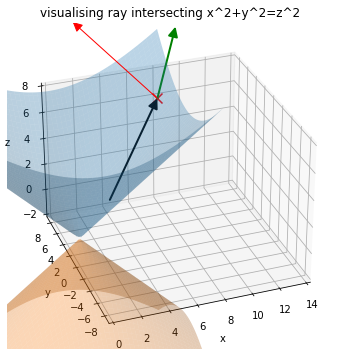

In [19]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,6))
ax.view_init(elev=30, azim=250, roll=0)
ax.set_xlim(-2,8)
ax.set_zlim(-2,8)
ax.set_xlim(0,14)
ax.plot_surface(X2, Y2, Z2, alpha=0.3, label='positive cone')
ax.plot_surface(X2, Y2, -Z2, alpha=0.3, label='negative cone')
ax.scatter(is2a[0],is2a[1],is2a[2], c='r', marker='x', s=100) 
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='k', shrinkA=0, shrinkB=0, linewidth=2)
a = Arrow3D([r2o[0], is2a[0]], [r2o[1], is2a[1]], [r2o[2], is2a[2]], **arrow_prop_dict)
ax.add_artist(a)
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='r', shrinkA=0, shrinkB=0, linewidth=1)
b = Arrow3D([is2a[0], is2a[0]-0.5*cn[0]], [is2a[1], is2a[1]-0.5*cn[1]], [is2a[2], is2a[2]-0.5*cn[2]], **arrow_prop_dict)
ax.add_artist(b)
tep2=3
ep2 = [float(rr2[0].subs({t:tep2})),float(rr2[1].subs({t:tep2})),float(rr2[2].subs({t:tep2}))]
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='g', shrinkA=0, shrinkB=0, linewidth=2)
b = Arrow3D([is2a[0], ep2[0]], [is2a[1], ep2[1]], [is2a[2], ep2[2]], **arrow_prop_dict)
ax.add_artist(b)
ax.title.set_text('visualising ray intersecting x^2+y^2=z^2')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z");

We can see from the above image that this is a tricky one to visualise and interpret. 

The incident ray actually begins above the blue surface, and intersects the cone as the surface curves upwards.

The normal (shown in red) shows that the ray has only glanced off the surface, meaning that the reflected ray vector (green) isn't strongly deflected from the original direction.

I recommend changing the viewing angle (and potentially playing with the plotting ranges of $x$, $y$ and $z$) to confirm that this is the correct result.

## Over to you
The aim of this course is to familiarise and become an expert in the mathematics underpinning several common standard games tools and techniques. You should carry out the questions in the tutorial booklet **by hand** to practice this mathematics and prepare for the exam. However, particularly in this topic, the mathematics is not easily visualised; having completed the maths exercises, try and visualise some of the solutions you have created to verify the ray behaviour. 